In [1]:
# 필요한 라이브러리 임포트
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
import numpy as np
import pandas as pd

from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# GPU 설정 (A5000 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
!nvidia-smi

/home/billy/anaconda3/envs/llama2-7b/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/billy/anaconda3/envs/llama2-7b/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please sub

Device: cuda
Sun Nov 17 22:53:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.28.03              Driver Version: 560.28.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   22C    P8             10W /  230W |     822MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------------

In [2]:
# 레이블 인코딩 (항목 열을 숫자로 변환)
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('field.csv')

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['항목'])

# 레이블과 인코딩된 값 출력
print("레이블 인코딩 결과:")
for label, index in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {index}")

# 학습 데이터와 테스트 데이터로 분할 (stratify로 레이블 분포 유지)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['대화'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

df.tail(4)

레이블 인코딩 결과:
가정폭력_우려: 0
가정폭력_위험: 1
가정폭력_주의: 2
방임_우려: 3
방임_위험: 4
방임_주의: 5
성학대_우려: 6
성학대_위험: 7
신체학대_우려: 8
신체학대_위험: 9
신체학대_주의: 10
자해/자살_우려: 11
자해/자살_위험: 12
자해/자살_주의: 13
정서학대_우려: 14
정서학대_위험: 15
정서학대_주의: 16
트라우마_우려: 17
트라우마_위험: 18
트라우마_주의: 19
학교폭력_우려: 20
학교폭력_위험: 21
학교폭력_주의: 22
해당없음: 23


,항목,대화,label
4976,트라우마_우려,Q: 잠잘 때 주로 어떤 꿈을 꿔? A: 기억이 안 나요. 근데 일어나면 기분이 좋...,17
4977,신체학대_위험,Q: 주위 어른들 중 나를 때린 적이 있는 사람이 있나요? A: 엄마 남친이요. Q...,9
4978,가정폭력_위험,Q: 가족들끼리 소리를 지르면서 싸우는 걸 듣거나 본 적이 있어요? A: 엄마랑 아...,1
4979,방임_우려,Q: 집에서 주로 나를 돌봐주는 어른은 누구인가요? A: 엄마세요. Q: 배가 고픈...,3


In [3]:
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("monologg/kobert", num_labels=len(label_encoder.classes_))
tokenizer = AutoTokenizer.from_pretrained("monologg/kobert", trust_remote_code=True)
model.to(device)

# 커스텀 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # 텍스트를 토크나이즈하고 텐서로 변환
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# 데이터로더 생성
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:

# 옵티마이저와 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3  # 총 학습 스텝

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 손실 함수 정의 (CrossEntropyLoss)
loss_fn = nn.CrossEntropyLoss().to(device)

# 학습 함수 정의
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()

    losses = []
    correct_preds = 0

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_preds += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 그래디언트 클리핑
        optimizer.step()
        scheduler.step()

    return correct_preds.double() / len(data_loader.dataset), np.mean(losses)

# 평가 함수 정의
def eval_model(model, data_loader, loss_fn, device):
    model.eval()

    losses = []
    correct_preds = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_preds += torch.sum(preds == labels)
            losses.append(loss.item())

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return correct_preds.double() / len(data_loader.dataset), np.mean(losses), predictions, true_labels


In [5]:

# 학습 및 평가 루프
EPOCHS = 5  # 에폭 수

for epoch in range(EPOCHS):
    print(f'에폭 {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )

    print(f'훈련 손실 {train_loss:.4f}, 정확도 {train_acc:.4f}')

    val_acc, val_loss, _, _ = eval_model(
        model,
        test_loader,
        loss_fn,
        device
    )

    print(f'검증 손실 {val_loss:.4f}, 정확도 {val_acc:.4f}')


에폭 1/5
----------
훈련 손실 1.9165, 정확도 0.5695
검증 손실 1.1274, 정확도 0.6898
에폭 2/5
----------
훈련 손실 1.0218, 정확도 0.7018
검증 손실 0.8745, 정확도 0.7269
에폭 3/5
----------
훈련 손실 0.8625, 정확도 0.7319
검증 손실 0.8019, 정확도 0.7520
에폭 4/5
----------
훈련 손실 0.8247, 정확도 0.7447
검증 손실 0.8019, 정확도 0.7520
에폭 5/5
----------
훈련 손실 0.8254, 정확도 0.7460
검증 손실 0.8019, 정확도 0.7520


In [6]:
# Save paths
from datetime import datetime

cur_time_str = datetime.now().strftime("%Y%m%d%H%M%S")
model_save_path = f'model_{cur_time_str}/'

# Save the trained model
model.save_pretrained(model_save_path)
print("Model saved successfully.")

Model saved successfully.


In [7]:
model = AutoModelForSequenceClassification.from_pretrained(model_save_path, num_labels=len(label_encoder.classes_))
tokenizer = AutoTokenizer.from_pretrained("monologg/kobert", trust_remote_code=True)
model.to(device)

# 테스트 데이터에서 모델 평가
test_acc, test_loss, y_pred, y_true = eval_model(
    model,
    test_loader,
    loss_fn,
    device
)

print(f'테스트 손실 {test_loss:.4f}, 정확도 {test_acc:.4f}')

# 분류 리포트 생성 (정밀도, 재현율 등)
print('\n분류 리포트:')
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))


테스트 손실 0.8019, 정확도 0.7520

분류 리포트:
              precision    recall  f1-score   support

     가정폭력_우려     0.8333    0.4545    0.5882        22
     가정폭력_위험     0.8000    0.9778    0.8800        45
     가정폭력_주의     0.0000    0.0000    0.0000         2
       방임_우려     0.6364    0.7241    0.6774        58
       방임_위험     0.7879    0.6047    0.6842        43
       방임_주의     0.0000    0.0000    0.0000         2
      성학대_우려     0.0000    0.0000    0.0000        15
      성학대_위험     0.7368    0.9767    0.8400        43
     신체학대_우려     0.0000    0.0000    0.0000        25
     신체학대_위험     0.7984    1.0000    0.8879       103
     신체학대_주의     0.0000    0.0000    0.0000         3
    자해/자살_우려     0.8182    1.0000    0.9000        72
    자해/자살_위험     0.0000    0.0000    0.0000        15
    자해/자살_주의     0.0000    0.0000    0.0000         1
     정서학대_우려     0.7539    0.9931    0.8571       145
     정서학대_위험     0.0000    0.0000    0.0000        41
     정서학대_주의     0.0000    0.0000    0.0000   

/home/billy/anaconda3/envs/llama2-7b/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/billy/anaconda3/envs/llama2-7b/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/billy/anaconda3/envs/llama2-7b/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [8]:
import matplotlib as mpl
import matplotlib.font_manager as fm

hasKoreanFont = len([f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]) > 0
if hasKoreanFont:
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rcParams['axes.unicode_minus'] = False

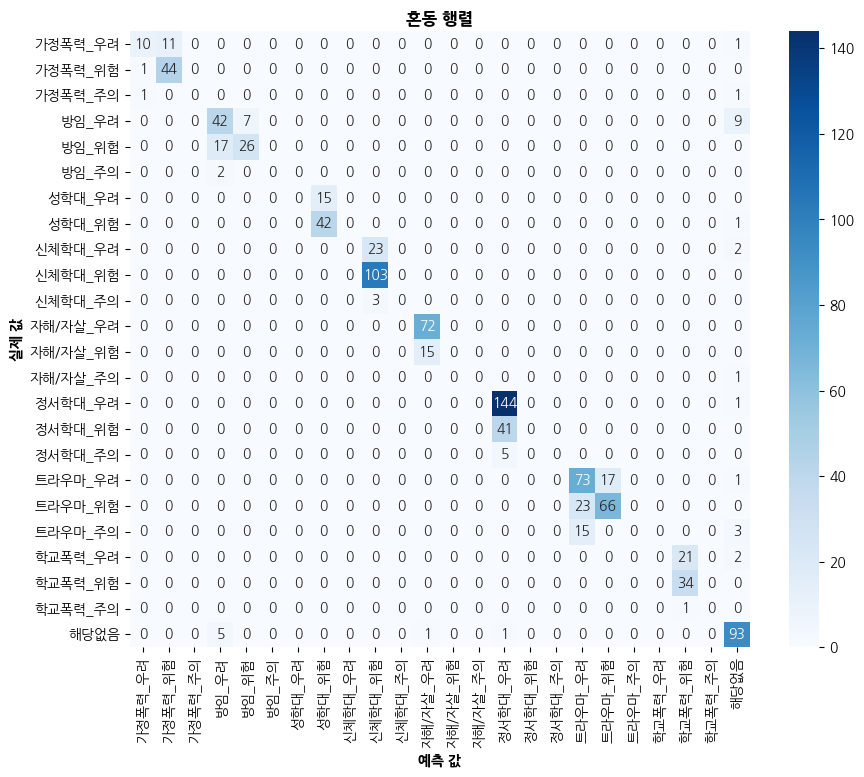

In [9]:
# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('실제 값', weight='bold')
plt.xlabel('예측 값', weight='bold')
plt.title('혼동 행렬', weight='bold', size=12)
plt.show()